# Using U-net style architecture for semantic segmentation
I will train a u-net-style architecture on the labeled city dataset from CityScapes.

### Params

In [0]:
#centralized location for params needing tweaked
batch_size = 4
target_size = (512,256)
n_epochs = 25
learning_rate = 0.000_001
run_once, fix_masks = False, False # to load/unzip/fix data, fix masks
seed = 42

## Environment

In [7]:
# get colab status
try:
  import google.colab
  IN_COLAB = True
  %tensorflow_version 2.x
except:
  IN_COLAB = False

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.train import exponential_decay
from tensorflow.keras import metrics 
from tensorflow.keras import models
from tensorflow.keras.layers import (Dense, Conv2D, Flatten, Dropout, 
MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate, Input)
from tensorflow.keras.utils import Sequence 
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.utils.data_utils import Sequence # to fix 'imagedatagenerator has no shape' error
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import os, zipfile, glob, shutil
from math import ceil 
from PIL import Image
from skimage import io, transform
import imageio.core.util  # so can be patched
import warnings

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir(r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/')
else:
    os.chdir(os.path.expanduser(r'~/Google Drive/thinkful/colab_datasets/sidewalk_data/'))
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data


# Data Load
### Cityscape Dataset
This is a publically availible dataset from https://www.cityscapes-dataset.com/, though not downloadable without requesting a login which is granted based on email domain.
Citation:  
>Cvpr2016M. Cordts, M. Omran, S. Ramos, T. Rehfeld, M. Enzweiler, R. Benenson, U. Franke, S. Roth, and B. Schiele, “The Cityscapes Dataset for Semantic Urban Scene Understanding,” in Proc. of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016. [Bibtex]
[main paper](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes.pdf) · [supplemental ](https://www.cityscapes-dataset.com/wordpress/wp-content/papercite-data/pdf/cordts2016cityscapes-supplemental.pdf)· [arxiv](http://arxiv.org/abs/1604.01685) · [CVF](http://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Cordts_The_Cityscapes_Dataset_CVPR_2016_paper.html)


In [0]:
if run_once: # run once
  os.chdir(r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/')
  with zipfile.ZipFile(os.path.join(os.getcwd(), 'gtFine_trainvaltest.zip'), 'r') as zip_ref:
    zip_ref.extractall("./cityscape/")

In [0]:
#Color for sidewalk in mask from cityscape website:
sidewalk_color = np.array([244, 35, 232])
sidewalk_colorl = [244, 35, 232]

### Downsample images and fix directory structure

In [0]:
def resize(path, destination):
    '''
    downsample images by 4x, 
    remove transparency layer, 
    save to flattened dir stuc
    Args:
        path = current directory
        destination = destination for images
    '''
    dirs1 = np.array([os.path.join(path, x) for x in os.listdir(path)])
    dirs = dirs1[[os.path.isdir(x) for x in dirs1]]
    for direc in dirs:   # direc should be mask vs image folders
        if not os.path.isdir(direc):
            continue
        subdirs = [os.path.join(direc, x) for x in os.listdir(direc)]
        for subdir in subdirs:   # subdir should be train, val, test
            subdirs2 = [os.path.join(subdir, x) for x in os.listdir(subdir)]
            for subdir2 in subdirs2:   # subdir2 is city folders
                items = os.listdir(subdir2)
                for item in items:
                    if not os.path.isfile(os.path.join(subdir2,item)):
                        continue
                    #skip json and noncolor masks
                    if item.rfind('gtFine_color.png') == -1 \
                    and item.rfind('leftImg8bit.png') == -1:
                        continue
                    #if item.rfind('leftImg8bit.png') != -1:  # remove if doing images
                    #    continue
                    destin2 = os.path.join(destination, subdir[len(common_path)+1:])
                    f, _ = os.path.splitext(item)
                    if not os.path.exists(destin2):
                        os.makedirs(destin2)
                    destin3 = os.path.join(destin2, f+'_resized.png')
                    ###########WARNING
                    #ADDED transfomation for masks. IF running 
                    #from scratch, add logic to treat masks vs images separately
                    ###############
                    #filename = os.path.join(subdir2, item)
                    #im = io.imread(filename)
                    #im = im[:,:,0:3]  # remove alpha channel
                    #reduced_im = np.apply_along_axis(color_checker, 2, im).astype(np.intc)
                    #reduced_im = transform.resize(reduced_im, 
                    #                            (256,512), 
                    #                            preserve_range=True, 
                    #                            anti_aliasing=False).astype(np.bool_).astype(np.intc)
                    #io.imsave(destin3, reduced_im) 



                    im = Image.open(os.path.join(subdir2, item))
                    if im.mode == "RGBA":
                        im = im.convert('RGB')
                    im = im.resize((512,256), Image.BICUBIC)
                    im.save(destin3, format='PNG')
                    im.close()

In [13]:
#switch to cloud dir
if IN_COLAB:
    data_mount = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/'  
    destin = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/'
else:
    data_mount = r'C:\Users\User\Google Drive\thinkful\colab_datasets\sidewalk_data\public_data'
    destin = r"C:\Users\User\Google Drive\thinkful\colab_datasets\sidewalk_data\public_data\cityscape_reduced"
leftimages_path = os.path.join(data_mount, r'cityscape/leftImg8bit/') # no leading /
mask_path = os.path.join(data_mount, r'cityscape/gtFine/')
common_path = os.path.join(data_mount, r'cityscape')
image_dest_path = os.path.join(destin, r'leftImg8bit')
mask_dest_path = os.path.join(destin, r'sidewalk_only_masks')
os.chdir(common_path)
!pwd

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape


In [0]:
if run_once:
  resize(common_path, destin)

## Adjust masks to only separate sidewalk vs non-sidewalk

In [15]:
! pwd

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape


In [0]:
#Requires both patching library and regular filterwarnings to avoid 
#warnings about low resolution!
def silence_imageio_warning(*args, **kwargs):
    pass
imageio.core.util._precision_warn = silence_imageio_warning

#### Create dataframe of mask files to operate on and intended output filename

In [0]:
os.chdir(mask_path)
if fix_masks:
    file_list = ! find . -name "*_gtFine_color.png"
    mask_fixes_df = pd.DataFrame([path.split("/") for path in file_list])
    mask_fixes_df.columns = ['dot', 'subset', 'city', 'filename']
    mask_fixes_df['dest_path'] = destin + r'/sidewalk_only_masks/' + \
    mask_fixes_df.subset + '/folder0/' + mask_fixes_df.filename
    mask_fixes_df['old_path'] = file_list
    mask_fixes_df['old_path'] = mask_fixes_df['old_path'].apply(lambda x: mask_path + x[2:])
    mask_fixes_df = mask_fixes_df[mask_fixes_df.subset != 'test']

In [0]:
def remove_extant(path):
    return True if os.path.exists(path) else False
mask_fixes_df['already_fixed'] = mask_fixes_df.dest_path.apply(remove_extant)

In [0]:
mask_fixes_df[mask_fixes_df.already_fixed == False]

In [0]:
def mask_reduce(old_file, new_file):
    '''reduces images from rgb to b/w mask'''
    im = io.imread(old_file)
    im = im[:,:,0:3]  # remove alpha channel
    #reduced_im = np.apply_along_axis(color_checker, 2, im).astype(np.intc)
    reduced_im = (im == sidewalk_colorl).all(-1)  # SO. MUCH. FASTER.
    reduced_im = transform.resize(reduced_im, 
                                  (256,512), 
                                  preserve_range=True, 
                                  anti_aliasing=False).astype(np.bool_).astype(np.intc)
    #all black images throw error
    try:
        io.imsave(new_file, reduced_im) 
    except ValueError:
        io.imsave(new_file, reduced_im.astype('float64'))

### Find masks not yet created and do so

In [0]:
if fix_masks:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        warnings.filterwarnings('ignore')
        #apply fix to mask file w/o extant target
        mask_fixes_df[mask_fixes_df.already_fixed==False]\
            .apply(lambda x: mask_reduce(x.old_path, x.dest_path), axis=1)

In [0]:
os.chdir(destin)

In [0]:
#create some subfolders for flow_for_directory
if run_once:
    subset = ['train', 'test', 'val']
    pathset = [mask_dest_path, image_dest_path]
    for sub in subset:
        for path in pathset:
            new_path = os.path.join(path, sub, 'folder0')
            if not os.path.exists(new_path):
                os.mkdir(new_path)
            file_listing = os.listdir(os.path.join(path,sub))
            file_listing = [file for file in file_listing if file!=new_path]        
            for file in file_listing:
                src=os.path.join(path,sub,file)
                dst=os.path.join(new_path,file)
                try:
                    shutil.move(src,dst)
                except OSError:
                    pass

/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/train/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/leftImg8bit/train/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/test/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/leftImg8bit/test/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/sidewalk_only_masks/val/folder0
/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/public_data/cityscape_reduced/leftImg8bit/val/folder0


# Data Generator

In [0]:
def get_image_locs(subset, im_path, add_folder0):    
    '''grab name of every image 
    and store in dataframe with subset eg. train, test'''
    df = pd.DataFrame(columns=['img_name', 'subset'])
    os.chdir(im_path)   # needed despite lack of reference to curpath
    img_paths = os.listdir(im_path) 
    if subset == 'img':
        search_for = '*/*'
    elif subset == 'mask':   
        search_for = '*/*_gtFine_color.png'
    else:
        raise NameError("subset should be 'img' or 'mask'")
    if add_folder0:
        im_paths = [os.path.join(im, 'folder0') for im in im_paths]
    for subsetdir in img_paths:
        img_files = [x[len(subsetdir)+1:] for x in glob.glob(os.path.join(subsetdir, search_for))]
        img_files_s = pd.Series(img_files)
        new_df = None
        new_df = pd.DataFrame(columns=['img_name', 'subset'])
        new_df['img_name'] = img_files_s
        new_df['subset'].fillna(subsetdir, inplace=True)
        df = df.append(new_df)
    return df

In [0]:
def clean_name(name):
  '''removes _gtFine_color.png or _leftImg8bit.png'''
  which = name.rfind('_leftImg8bit.png')
  if which == -1:
    which = '_gtFine_color.png'
  else:
    which =  '_leftImg8bit.png'
  loc=name.rfind(which)
  return name[:loc]

In [0]:
data_df = get_image_locs('img', leftimages_path, False)
mask_df = get_image_locs('mask', mask_path, False)

In [0]:
data_df['common_name'] = data_df.img_name.apply(clean_name)
mask_df['common_name'] = mask_df.img_name.apply(clean_name)
data_full_df = None
data_full_df = pd.merge(left=data_df, right=mask_df, 
                        how='inner', on='common_name',
                        sort=False, 
                        suffixes=('_data', '_mask'))\
               [['img_name_data', 'subset_data', 'img_name_mask']]
data_full_df.columns = ['img_name', 'subset_data', 'mask_name']

### ImageDataGenerator class

In [0]:
#check all images have masks and vice-versa
def check_im_mask_overlap(im_path, mask_path):
    '''
    Args:
        how: pd.merge how=, as str. 
        inner for mask/image matchs, left for images WO mask, right mask WO img
    '''
    data_dest_df_img = get_image_locs('img', im_path, False)
    mask_dest_df_mask = get_image_locs('mask', mask_path, False)
    #print(data_dest_df_img[data_dest_df_img.duplicated(subset='img_name', keep='first')])
    #print(mask_dest_df_mask[mask_dest_df_mask.duplicated(subset='img_name', keep='first')])
    data_dest_df, mask_dest_df = pd.DataFrame(), pd.DataFrame()
    data_dest_df['common_name'] = data_df.img_name.apply(clean_name)
    mask_dest_df['common_name'] = mask_df.img_name.apply(clean_name)
    data_full_df = None
    data_full_df = pd.merge(left=data_df, right=mask_df, 
                            how='outer', on='common_name',
                            indicator=True, sort=False, 
                            suffixes=('_data', '_mask'))\
                [['img_name_data', 'subset_data', 'img_name_mask', '_merge']]
    data_full_df.columns = ['img_name', 'subset_data', 'mask_name', '_merge']
    return data_full_df
results = check_im_mask_overlap(image_dest_path, mask_dest_path)


In [24]:
#check that all images have masks and all masks have images
results.describe()

,img_name,subset_data,mask_name,_merge
count,5000,5000,5000,5000
unique,5000,3,5000,1
top,bremen/bremen_000297_000019_leftImg8bit.png,train,zurich/zurich_000096_000019_gtFine_color.png,both
freq,1,2975,1,5000


### Combined Generators

In [36]:
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)
seed=42
ffd_params = dict(class_mode=None,
                  target_size=target_size,
                  seed=seed,
                  batch_size=batch_size,
                  )
image_generator = image_datagen.flow_from_directory(
    os.path.join(image_dest_path, r'train'),
    **ffd_params)
mask_generator = mask_datagen.flow_from_directory(
    os.path.join(mask_dest_path, r'train'),
    color_mode='grayscale',
    **ffd_params)

image_generator_v = image_datagen.flow_from_directory(
    os.path.join(image_dest_path, r'val'),
    **ffd_params)
mask_generator_v = mask_datagen.flow_from_directory(
    os.path.join(mask_dest_path, r'val'),
    color_mode='grayscale',
    **ffd_params)

# combine generators into one which yields image and masks
def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

train_generator_ffd = combine_generator(image_generator, mask_generator)
val_generator_ffd = combine_generator(image_generator_v, mask_generator_v)

Found 2975 images belonging to 1 classes.
Found 2975 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


In [0]:
## Using Sequence to combine generators for better multiprocessing
class MergedGenerators(Sequence):
    def __init__(self, *generators):
        self.generators = generators
        # TODO add a check to verify that all generators have the same length

    def __len__(self):
        return int(np.ceil(len(self.generators[0]) / float(self.batch_size)))


    def __getitem__(self, index):
        return [generator[index] for generator in self.generators]
       
datagen_args = dict(class_mode=None,
                  target_size=target_size,
                  seed=seed,
                  batch_size=batch_size,
                  )

train_merged_generator = MergedGenerators(image_generator, mask_generator)

# Modeling
I will build a basic U-net model, train it on the cityscape public dataset, and use that model & weights on the Denver dataset I have built. 

Model structure reference [here](http://cs230.stanford.edu/files_winter_2018/projects/6937642.pdf)

### Build Visualizer

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def history_plotter(history, n_epochs, plot_validation=True): 
    '''plot the training loss and accuracy
    plot_validation exists because valdation not working in model
    '''
    n_epochs_range = np.arange(0, n_epochs)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                                  figsize=(10,5))
    ax1.plot(n_epochs_range, history.history["loss"], label="Loss")
    ax1.plot(n_epochs_range, history.history["accuracy"], label="Accuracy")
    iou = unet.metrics_names[2]
    ax1.plot(n_epochs_range, history.history[iou], label='Intersection over Union')
    ax1.plot(n_epochs_range, history.history['precision'], label='Precision')
    ax1.plot(n_epochs_range, history.history['recall'], label='Recall')
    if plot_validation:
        ax2.plot(n_epochs_range, history.history["val_loss"], label="loss")
        ax2.plot(n_epochs_range, history.history["val_accuracy"], label="Accuracy")
        ax2.plot(n_epochs_range, history.history["val_" + unet.metrics_names[2]], label="Intersection over Union")
        ax2.plot(n_epochs_range, history.history['val_precision'], label='Precision')
        ax2.plot(n_epochs_range, history.history['val_recall'], label='Recall')
    
    ax1.set_title("Training Metrics")
    ax2.set_title("Validation Metrics")
    plt.xlabel("Epoch #")
    ax1.set_ylabel("Metric Score")
    ax1.legend(); ax2.legend()
    plt.plot();

### Build Model

In [0]:
img_shape = (*target_size, 3)

In [0]:
#use function for the blocks of the network
def encoder_builder(input_, filters,
                         activ='relu', kernel=(3,3), 
                         drop=.5, pad='same', kern_init='he_uniform'):
  kwargs = {'filters': filters, 'activation': activ, 'kernel_size': kernel, 
       'padding': pad, 'kernel_initializer': kern_init}
  x = Conv2D(**kwargs)(input_)
  x = BatchNormalization()(x)
  x = Dropout(drop)(x)
  x = Conv2D(**kwargs)(x)
  encoder = Dropout(drop)(x)
  pooled = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)
  return encoder, pooled

def decoder_builder(input_, skip, filters, 
                    activ='relu', kernel=(2,2),
                    drop=.5, pad='same', kern_init='he_uniform',
                    ):
  kwargs = {'filters': filters, 'activation': activ, 'kernel_size': kernel, 
       'padding': pad, 'kernel_initializer': kern_init} 
  x = Conv2DTranspose(**kwargs, strides=(2,2))(input_)
  x = concatenate([x, skip], axis=-1)  # note axis is *-*1
  x = BatchNormalization()(x)
  x = Dropout(drop)(x)
  x = Conv2D(**kwargs)(x)
  x = BatchNormalization()(x)
  x = Dropout(drop)(x)
  x = Conv2D(**kwargs)(x)
  return x

In [0]:
input_layer = Input(shape=img_shape)
encoder1, pooled1 = encoder_builder(input_layer, filters=16)  # return (128x128x32)
encoder2, pooled2 = encoder_builder(pooled1, filters=32)  # return (64x64x364)
encoder3, pooled3 = encoder_builder(pooled2, filters=64)  # return (32x32x128)
encoder4, pooled4 = encoder_builder(pooled3, filters=128)  # return (16x16x256)
#encoder_builder(pooled4, filters=512)  # return (8x8x512)
middle, middle_pool = encoder_builder(pooled4, filters=128)  # return (4x4x1024)
#decoder512 = decoder_builder(middle, skip=encoder5, filters=512)
decoder256 = decoder_builder(middle, skip=encoder4, filters=128)
decoder128 = decoder_builder(decoder256, skip=encoder3, filters=64)
decoder64 = decoder_builder(decoder128, skip=encoder2, filters=32)
decoder32 = decoder_builder(decoder64, skip=encoder1, filters=16)
out_layer = Conv2D(filters=1, kernel_size=(1, 1), 
                   activation='sigmoid')(decoder32)   

In [0]:
unet = models.Model(inputs=[input_layer], outputs=[out_layer])

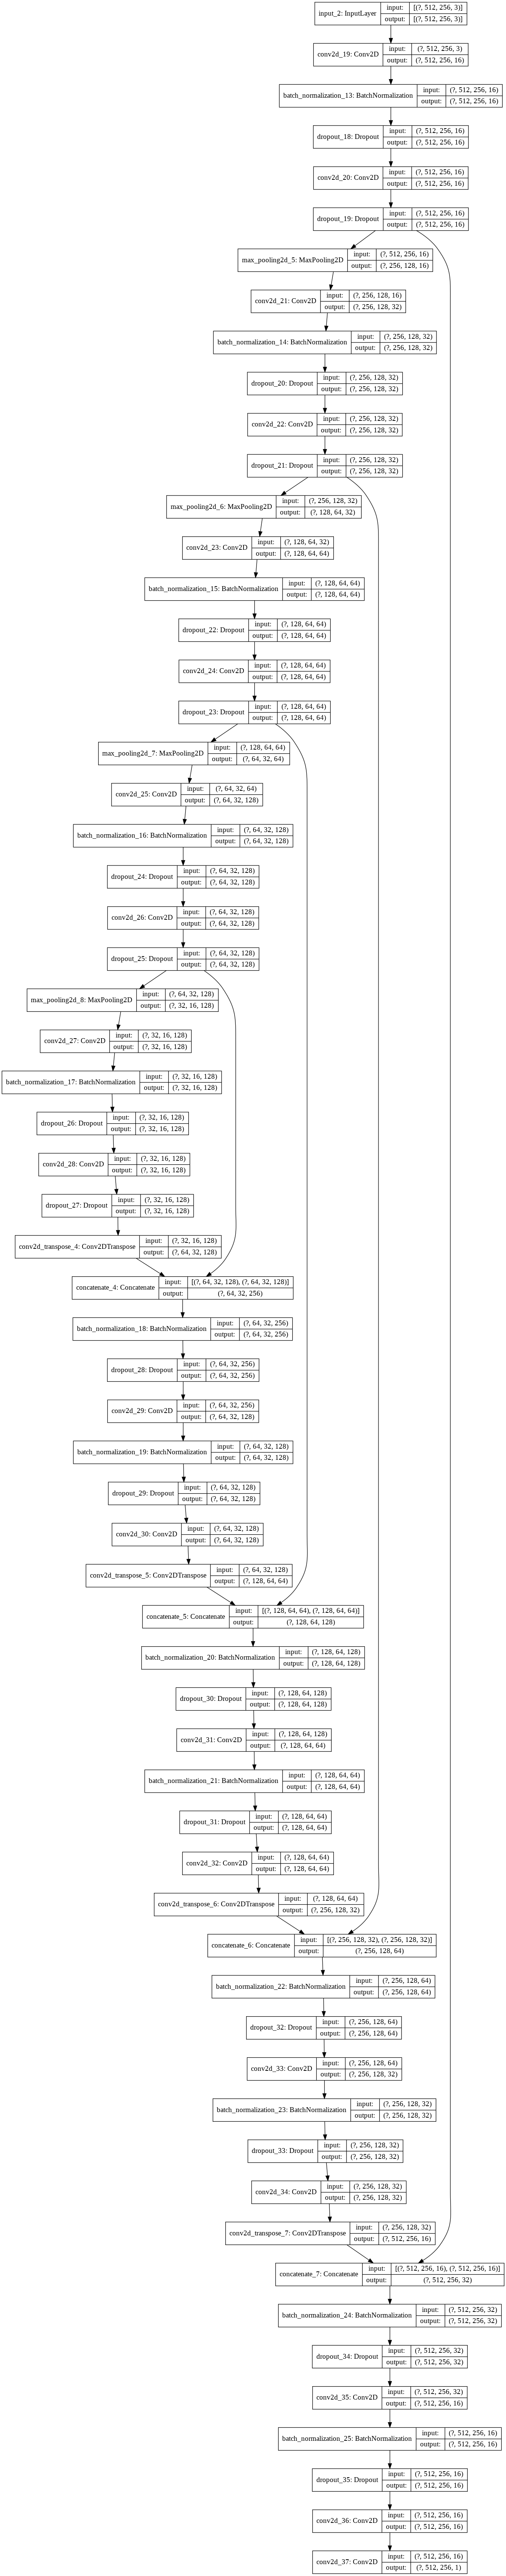

In [42]:
plot_model(unet, show_shapes=True, to_file='model.png')

### Model Prep

In [0]:
input_shape = img_shape
total_train_samples = data_full_df[data_full_df.subset_data == 'train'].shape[0]
total_vdate_samples = data_full_df[data_full_df.subset_data == 'val'].shape[0]

In [0]:
unet_model_path = r'/content/gdrive/My Drive/thinkful/colab_datasets/sidewalk_data/models/unet_weights.hdf5'
cb_params = dict(monitor=unet.metrics_names[2], 
                 save_best_only=True, 
                 verbose=1
                 )
unet_cb = ModelCheckpoint(filepath=unet_model_path, **cb_params)

In [47]:
model_metrics = ['accuracy', metrics.MeanIoU(num_classes=2), 'Precision', 'Recall']
unet.compile(optimizer=Adam(lr=learning_rate), 
             loss=binary_crossentropy, 
             metrics=model_metrics,
             )
unet.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 512, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 512, 256, 16) 0           batch_normalization_13[0][0]    

In [48]:
unet.metrics_names

['loss', 'acc', 'mean_io_u_2', 'precision', 'recall']

### Training

In [0]:
#estimated..TODO load sample of images, sum to scalar and divid by image size, 
#get average over image set 
class_weights = {0.0: 1, 1.0: 10}

In [51]:
unet_history = unet.fit_generator(
    train_generator_ffd, 
    steps_per_epoch=int(total_train_samples/batch_size),
    epochs=n_epochs,
    verbose=1,
    validation_data=val_generator_ffd,
    validation_steps=int(total_vdate_samples/batch_size),
    callbacks = [unet_cb])

Epoch 1/25
 28/743 [>.............................] - ETA: 51:37 - loss: 1.0320 - acc: 0.3891 - mean_io_u_2: 0.4705 - precision: 0.0611 - recall: 0.6512

KeyboardInterrupt: ignored

# Search for best learning rate

In [3]:
# decay_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
learning_rate_find = exponential_decay(1e-10, global_step=global_step, decay_steps=your_value, decay_rate=your_value)
# So it can be seen in TensorBoard later
tf.summary.scalar('learning_rate', learning_rate)

NameError: ignored

In [0]:
unet_lrfind.compile(optimizer=Adam(lr=learn), 
             loss=binary_crossentropy, 
             metrics=model_metrics,
             )
unet.summary()

In [0]:
class LearningRateFinder(Callback):
    '''find LR hyper by gradually increasing.
    code modified from https://www.avanwyk.com/finding-a-learning-rate-in-tensorflow-2/'''

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        #super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

  
  
    def on_train_batch_begin(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * 0.99
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)


    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    @tf.function
    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        print(f'learning rate now is {self.model.optimizer.lr}, will be set to {self.lr}')
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    @tf.function
    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [89]:
lr_finder = LearningRateFinder()

unet_lrfinder_history = unet.fit_generator(
    train_generator_ffd, 
    steps_per_epoch=int(total_train_samples/batch_size),
    epochs=n_epochs,
    verbose=1,
    validation_data=val_generator_ffd,
    validation_steps=int(total_vdate_samples/batch_size),
    callbacks = [unet_cb, lr_finder],
    use_multiprocessing=True)

Epoch 1/25
learning rate now is <tf.Variable 'training/Adam/learning_rate:0' shape=() dtype=float32>, will be set to Tensor("PartitionedCall:0", shape=(), dtype=float32)


TypeError: ignored

# Show Results

In [0]:
def plot_segmentation():
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    
    ax1.imshow(im, interpolation='none')
    ax1.set_title("Test Image")

    ax2.imshow(im, interpolation='none')
    ax2.imshow(mask_true, 'green', interpolation='none', alpha=.2)
    ax2.set_title("True Mask")

    ax3.imshow(im, interpolation='none')
    ax3.imshow(true_mask, 'green', interpolation='none', alpha=0.2)
    ax3.set_title("Predicted Mask")

    plt.show();